# Lambda School Data Science - Generative Adversarial Networks

![This Person Does Not Exist](https://thispersondoesnotexist.com/image)

# Lecture

## A plot made for Hollywood

Meet Gene:

![Gene Wilder](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Gene_Wilder_1970.JPG/379px-Gene_Wilder_1970.JPG)

Gene is the clever sort, and occasionally a bit mischievous. His goal is to **generate** things that trick Val:

![Val Kilmer](https://upload.wikimedia.org/wikipedia/commons/2/22/Val_Kilmer_Cannes.jpg)

Val has a simple job, but he takes it seriously - he wants to **validate** the authenticity of things that tricky Gene passes his way. Overall, Gene is a forger, and Val is a detective.

And as with all great mystery dramas, Gene and Val are essentially playing a sort of game. They compete, and in doing so drive each other to improve.

Considered as a GAN, Gene is the generator, and Val is the discriminator.

## *Two* neural networks - adversaries!

![Spy vs. Spy](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg/360px-Comikaze_Expo_2011_-_Spy_vs_Spy_%286325381362%29.jpg)

Generative Adversarial Networks is an approach to unsupervised learning, based on the insight that we can train *two* networks simultaneously and pit them against each other.

- The discriminator is trained with real - but unlabeled - data, and has the goal of identifying whether or not some new item belongs in it.
- The generator starts from noise (it doesn't see the data at all!), and tries to generate output to fool the discriminator (and gets to update based on feedback).

GANs can be considered a zero-sum game, in the [game theory](https://en.wikipedia.org/wiki/Game_theory) sense. Game theory is a common approach to modeling strategic competitive behavior between rational decision makers, and is heavily used in economics as well as computer science.

If you've also heard the hype about [reinforcement learning](https://en.wikipedia.org/wiki/Reinforcement_learning), one way to understand it is:

```
Reinforcement Learning : GAN :: Decision Theory : Game Theory
```

That is, Reinforcement Learning is more closely analogous to [decision theory](https://en.wikipedia.org/wiki/Decision_theory), a relative to the field of game theory, featuring the behavior of an "agent" against "nature" (the environment). The agent is strategic and rational, but the environment simply is.

## A Foray into Game Theory

What is a "zero sum" game? It is a model of the interaction of two strategic agents, in a situation where, for one to gain, the other must lose, and vice-versa.

A famous example is the [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner's_dilemma). The typical story behind this game is something like this:

> Two criminals who committed a crime together are caught by the authorities. There is enough evidence to put them each away for 3 years, but the police interrogate them separately, and offer each of them a deal - "Tell us what the other criminal did, and we'll go lighter on you."

> The deal is tempting - the person who takes it shaves 2 years off their sentence. But, it adds 5 years to the sentence of the other person. So if both talk, they both get 3 - 2 + 5 = 6 years, twice as much if they both don't. But if one talks and the other doesn't, the talker gets 1 year and the non-talker gets 8!

> The result is, individually, they both prefer defecting (talking with the police) regardless of what the other person does. But, they'd both be better off if they could somehow trust one another to not talk to the police.

Mathematically, we consider this outcome a *Nash equilibrium* - a stable situation where neither player would want to unilaterally change strategy. But, it's one where a *pareto superior* outcome exists (an outcome that both players would prefer to what they have now).

An illustration (with different numbers) of the Prisoner's Dilemma:

![Prisoner's Dilemmat](https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/Dilema_do_Prisioneiro.png/480px-Dilema_do_Prisioneiro.png)

More generally, these could be referred to as "constant sum" games - "zero sum" implies that for any player to get ahead, the other must inevitably end up behind. The above illustration could be of a game where people are "splitting loot", and so everybody *gets* something - it's just that some get more than others. The utility can be normalized so it sums to zero, or any other constant.

Game Theory is one of the core tools used in social science and other areas to model and explain behavior. The main path to overcome "dilemmas" is *iteration* - through repetition, players can have a reputation, and value that reputation more than the outcome in any single round. For example, think of the lengths some restaurants take to ensure positive reviews.

*Exercise* - think of at least two scenarios that could be explained with Prisoner's Dilemma, and of one other scenario that you think could also be modeled as some sort of strategic game between agents.

## Minimum Viable GAN

Courtesy of Keras:

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [8]:
np.random.seed(10)
random_dim = 100
 
def load_minst_data():
    # load the data - we'll use Fashion MNIST, for a change of pace
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [9]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [10]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0],
                                                    size=batch_size)]
 
            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])
 
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9
 
            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
 
            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
 
train(40, 64)

19136512/26421880 [====================>.........] - ETA: 12s

KeyboardInterrupt: 

Pretty decent results, even after not too many iterations.

We can do even better, with pretrained StyleGAN!

## StyleGAN - A Style-Based Generator Architecture for Generative Adversarial Networks

Original paper: https://arxiv.org/abs/1812.04948

Source code: https://github.com/NVlabs/stylegan

Many applications:
- https://thispersondoesnotexist.com
- https://thiscatdoesnotexist.com
- https://thisairbnbdoesnotexist.com
- https://stackroboflow.com

In [ ]:
!git clone https://github.com/NVlabs/stylegan
%cd stylegan/

In [ ]:
# From stylegan/pretrained_example.py

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config

def main():
    # Initialize TensorFlow.
    tflib.init_tf()

    # Load pre-trained network.
    url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
    with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
        _G, _D, Gs = pickle.load(f)
        # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
        # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
        # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

    # Print network details.
    Gs.print_layers()

    # Pick latent vector.
    rnd = np.random.RandomState(5)
    latents = rnd.randn(1, Gs.input_shape[1])

    # Generate image.
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

    # Save image.
    os.makedirs(config.result_dir, exist_ok=True)
    png_filename = os.path.join(config.result_dir, 'example.png')
    PIL.Image.fromarray(images[0], 'RGB').save(png_filename)

main()

In [ ]:
from IPython.display import Image
Image(filename='results/example.png')

# Assignment - ⭐ EmojiGAN ⭐

Using the provided "minimum viable GAN" code, train a pair of networks to generate emoji. To get you started, here's some emoji data:

In [11]:
!pip install emoji_data_python

In [12]:
!wget https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
!unzip emoji.zip

--2019-04-10 14:22:42--  https://github.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/raw/master/module3-generative-adversarial-networks/emoji.zip
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/master/module3-generative-adversarial-networks/emoji.zip [following]
--2019-04-10 14:22:42--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-4-Deep-Learning/master/module3-generative-adversarial-networks/emoji.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3407395 (3.2M) [application/zip]
Saving to: ‘emoji.zip’

emoji.zip           100%[===============

 extracting: emoji/1f435.png         
 extracting: emoji/1f436.png         
 extracting: emoji/1f437.png         
 extracting: emoji/1f438.png         
 extracting: emoji/1f439.png         
 extracting: emoji/1f43a.png         
 extracting: emoji/1f43b.png         
 extracting: emoji/1f43c.png         
 extracting: emoji/1f43d.png         
 extracting: emoji/1f43e.png         
 extracting: emoji/1f440.png         
 extracting: emoji/1f442.png         
 extracting: emoji/1f443.png         
 extracting: emoji/1f444.png         
 extracting: emoji/1f445.png         
 extracting: emoji/1f446.png         
 extracting: emoji/1f447.png         
 extracting: emoji/1f448.png         
 extracting: emoji/1f449.png         
 extracting: emoji/1f44a.png         
 extracting: emoji/1f44b.png         
 extracting: emoji/1f44c.png         
 extracting: emoji/1f44d.png         
 extracting: emoji/1f44e.png         
 extracting: emoji/1f44f.png         
 extracting: emoji/1f450.png         
 extracting:

 extracting: emoji/1f631.png         
 extracting: emoji/1f632.png         
 extracting: emoji/1f633.png         
 extracting: emoji/1f634.png         
 extracting: emoji/1f635.png         
 extracting: emoji/1f636.png         
 extracting: emoji/1f637.png         
 extracting: emoji/1f638.png         
 extracting: emoji/1f639.png         
 extracting: emoji/1f63a.png         
 extracting: emoji/1f63b.png         
 extracting: emoji/1f63c.png         
 extracting: emoji/1f63d.png         
 extracting: emoji/1f63e.png         
 extracting: emoji/1f63f.png         
 extracting: emoji/1f640.png         
 extracting: emoji/1f645.png         
 extracting: emoji/1f646.png         
 extracting: emoji/1f647.png         
 extracting: emoji/1f648.png         
 extracting: emoji/1f649.png         
 extracting: emoji/1f64a.png         
 extracting: emoji/1f64b.png         
 extracting: emoji/1f64c.png         
 extracting: emoji/1f64d.png         
 extracting: emoji/1f64e.png         
 extracting:

In [13]:
import imageio
import matplotlib.pyplot as plt
from skimage import color

example_emoji = imageio.imread('emoji/1f683.png')
grayscale_emoji = color.rgb2gray(example_emoji)

In [14]:
example_emoji.shape

(28, 28, 4)

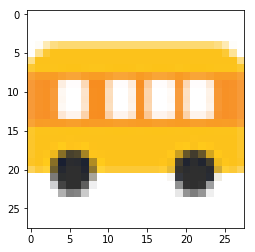

In [15]:
plt.imshow(example_emoji);

In [16]:
grayscale_emoji.shape

(28, 28)

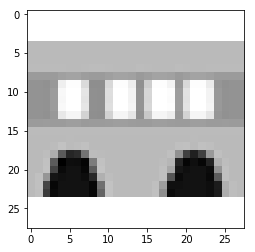

In [17]:
plt.imshow(grayscale_emoji, cmap="gray");

**Your goal** - *train a GAN that makes new emoji!*

The good news - the data is naturally 28x28, which is the same size as the earlier example (resulting in an input layer size of $28 \times 28=784$). It's big enough to kinda look like a thing, but small enough to be feasible to train with limited resources.

The bad news - the emoji are 4 layer PNGs (RGBA), and grayscale conversion is inconsistent at best (the above looks pretty good, but experiment and you'll see). It's OK to convert to grayscale and train that way to start (since it'll pretty much drop in to the example code with minimal modification), but you may want to see if you can figure out handling all 4 layers of the input image (basically - growing the dimensionality of the data).

The worse news - this dataset may not be large enough to get the same quality of results as MNIST. The resources/stretch goals section links to additional sources, so feel free to get creative (and practice your scraping/ingest skills) - but, it is suggested to do so only *after* working some with this as a starting point.

*Hint* - the main challenge in getting an MVP running will just be loading and converting all the images. [os.listdir](https://docs.python.org/3.7/library/os.html#os.listdir) plus a loop, and refactoring the image processing code into a function, should go a long way.

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # performance timing

from PIL import Image

# Building on Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

In [109]:
np.random.seed(101)
data_dim = 3      # number of dimensions of data for each pixel
random_dim = 147  # This value must be divisible by data_dim.
                  # If not, we will split the last pixel's dimensions
                  # between two sets of data that we feed to the network.
                  # We should also be able to integer divide the number of values
                  # in each emoji by this number. We found this number

def load_emoji_data():
    emojis = []
    for filename in os.listdir('./emoji'):
        im = Image.open('./emoji/' + filename)
        pixels = np.delete(np.array(im), data_dim, axis=2)
        emojis.append(pixels)
        
    x_train = np.reshape(np.array(emojis), (861, 784 * data_dim))
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    return x_train, None, None, None

load_emoji_data()

(array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [-0.49803922,  0.5058824 ,  0.8117647 , ..., -0.49803922,
          0.5058824 ,  0.8117647 ],
        [-0.49803922,  0.5058824 ,  0.8117647 , ..., -0.49803922,
          0.5058824 ,  0.8117647 ],
        ...,
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 1.        ,  1.        ,  1.        , ...,  1.        ,
          1.        ,  1.        ],
        [-0.49803922,  0.5058824 ,  0.8117647 , ..., -0.49803922,
          0.5058824 ,  0.8117647 ]], dtype=float32), None, None, None)

In [129]:
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, input_dim=784 * data_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
 
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, input_dim=random_dim,
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))
 
    generator.add(Dense(784 * data_dim, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real/not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),
                          figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28, 3)
    generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)
 
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

  0%|          | 0/13 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.19it/s]

--------------- Epoch 2 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.62it/s]

--------------- Epoch 3 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.78it/s]

--------------- Epoch 4 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.37it/s]

--------------- Epoch 5 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.74it/s]

--------------- Epoch 6 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.50it/s]

--------------- Epoch 7 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 8 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.29it/s]

--------------- Epoch 9 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 10 ---------------


  8%|▊         | 1/13 [00:00<00:02,  5.98it/s]

--------------- Epoch 11 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.81it/s]

--------------- Epoch 12 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.38it/s]

--------------- Epoch 13 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.16it/s]

--------------- Epoch 14 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 15 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.33it/s]

--------------- Epoch 16 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.86it/s]

--------------- Epoch 17 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.37it/s]

--------------- Epoch 18 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 19 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.63it/s]

--------------- Epoch 20 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.28it/s]

--------------- Epoch 21 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.39it/s]

--------------- Epoch 22 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.20it/s]

--------------- Epoch 23 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.17it/s]

--------------- Epoch 24 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.09it/s]

--------------- Epoch 25 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.82it/s]

--------------- Epoch 26 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.52it/s]

--------------- Epoch 27 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.99it/s]

--------------- Epoch 28 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.03it/s]

--------------- Epoch 29 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.96it/s]

--------------- Epoch 30 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.92it/s]

--------------- Epoch 31 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.52it/s]

--------------- Epoch 32 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.86it/s]

--------------- Epoch 33 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.02it/s]

--------------- Epoch 34 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.22it/s]

--------------- Epoch 35 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.92it/s]

--------------- Epoch 36 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.08it/s]

--------------- Epoch 37 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.89it/s]

--------------- Epoch 38 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.43it/s]

--------------- Epoch 39 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.35it/s]

--------------- Epoch 40 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.65it/s]

--------------- Epoch 41 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.11it/s]

--------------- Epoch 42 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.66it/s]

--------------- Epoch 43 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.58it/s]

--------------- Epoch 44 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.03it/s]

--------------- Epoch 45 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.77it/s]

--------------- Epoch 46 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.91it/s]

--------------- Epoch 47 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.06it/s]

--------------- Epoch 48 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.33it/s]

--------------- Epoch 49 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.15it/s]

--------------- Epoch 50 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.72it/s]

--------------- Epoch 51 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.02it/s]

--------------- Epoch 52 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.17it/s]

--------------- Epoch 53 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.32it/s]

--------------- Epoch 54 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.69it/s]

--------------- Epoch 55 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.64it/s]

--------------- Epoch 56 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.16it/s]

--------------- Epoch 57 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.76it/s]

--------------- Epoch 58 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.21it/s]

--------------- Epoch 59 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.78it/s]

--------------- Epoch 60 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.65it/s]

--------------- Epoch 61 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.64it/s]

--------------- Epoch 62 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 63 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.83it/s]

--------------- Epoch 64 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.40it/s]

--------------- Epoch 65 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.96it/s]

--------------- Epoch 66 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.17it/s]

--------------- Epoch 67 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.09it/s]

--------------- Epoch 68 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.88it/s]

--------------- Epoch 69 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.98it/s]

--------------- Epoch 70 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.19it/s]

--------------- Epoch 71 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.02it/s]

--------------- Epoch 72 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.14it/s]

--------------- Epoch 73 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.71it/s]

--------------- Epoch 74 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.79it/s]

--------------- Epoch 75 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.32it/s]

--------------- Epoch 76 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.72it/s]

--------------- Epoch 77 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.91it/s]

--------------- Epoch 78 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.54it/s]

--------------- Epoch 79 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.14it/s]

--------------- Epoch 80 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.38it/s]

--------------- Epoch 81 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.70it/s]

--------------- Epoch 82 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.85it/s]

--------------- Epoch 83 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.70it/s]

--------------- Epoch 84 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.90it/s]

--------------- Epoch 85 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 86 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.34it/s]

--------------- Epoch 87 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.93it/s]

--------------- Epoch 88 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.53it/s]

--------------- Epoch 89 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.00it/s]

--------------- Epoch 90 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.94it/s]

--------------- Epoch 91 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.03it/s]

--------------- Epoch 92 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.80it/s]

--------------- Epoch 93 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.71it/s]

--------------- Epoch 94 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 95 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.81it/s]

--------------- Epoch 96 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.44it/s]

--------------- Epoch 97 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.92it/s]

--------------- Epoch 98 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.32it/s]

--------------- Epoch 99 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 100 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.43it/s]

--------------- Epoch 101 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.31it/s]

--------------- Epoch 102 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.86it/s]

--------------- Epoch 103 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.57it/s]

--------------- Epoch 104 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.66it/s]

--------------- Epoch 105 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.92it/s]

--------------- Epoch 106 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.45it/s]

--------------- Epoch 107 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.78it/s]

--------------- Epoch 108 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.57it/s]

--------------- Epoch 109 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.76it/s]

--------------- Epoch 110 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.38it/s]

--------------- Epoch 111 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.93it/s]

--------------- Epoch 112 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.98it/s]

--------------- Epoch 113 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 114 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.41it/s]

--------------- Epoch 115 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.47it/s]

--------------- Epoch 116 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.35it/s]

--------------- Epoch 117 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.71it/s]

--------------- Epoch 118 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.50it/s]

--------------- Epoch 119 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.78it/s]

--------------- Epoch 120 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.85it/s]

--------------- Epoch 121 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.63it/s]

--------------- Epoch 122 ---------------


  8%|▊         | 1/13 [00:00<00:01,  6.93it/s]

--------------- Epoch 123 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.64it/s]

--------------- Epoch 124 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.16it/s]

--------------- Epoch 125 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.92it/s]

--------------- Epoch 126 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 127 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.03it/s]

--------------- Epoch 128 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.53it/s]

--------------- Epoch 129 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.80it/s]

--------------- Epoch 130 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.31it/s]

--------------- Epoch 131 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.67it/s]

--------------- Epoch 132 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.64it/s]

--------------- Epoch 133 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.28it/s]

--------------- Epoch 134 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.78it/s]

--------------- Epoch 135 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.83it/s]

--------------- Epoch 136 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.38it/s]

--------------- Epoch 137 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.54it/s]

--------------- Epoch 138 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.41it/s]

--------------- Epoch 139 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.42it/s]

--------------- Epoch 140 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.30it/s]

--------------- Epoch 141 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.53it/s]

--------------- Epoch 142 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.90it/s]

--------------- Epoch 143 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.36it/s]

--------------- Epoch 144 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.88it/s]

--------------- Epoch 145 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.36it/s]

--------------- Epoch 146 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.79it/s]

--------------- Epoch 147 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.80it/s]

--------------- Epoch 148 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.93it/s]

--------------- Epoch 149 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 150 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.59it/s]

--------------- Epoch 151 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.56it/s]

--------------- Epoch 152 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 153 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.36it/s]

--------------- Epoch 154 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.56it/s]

--------------- Epoch 155 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.63it/s]

--------------- Epoch 156 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.66it/s]

--------------- Epoch 157 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.05it/s]

--------------- Epoch 158 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.65it/s]

--------------- Epoch 159 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.77it/s]

--------------- Epoch 160 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.67it/s]

--------------- Epoch 161 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.91it/s]

--------------- Epoch 162 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.53it/s]

--------------- Epoch 163 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.43it/s]

--------------- Epoch 164 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.85it/s]

--------------- Epoch 165 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.30it/s]

--------------- Epoch 166 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.12it/s]

--------------- Epoch 167 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.06it/s]

--------------- Epoch 168 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.76it/s]

--------------- Epoch 169 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.89it/s]

--------------- Epoch 170 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.96it/s]

--------------- Epoch 171 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.56it/s]

--------------- Epoch 172 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.71it/s]

--------------- Epoch 173 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 174 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.35it/s]

--------------- Epoch 175 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.67it/s]

--------------- Epoch 176 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.09it/s]

--------------- Epoch 177 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.47it/s]

--------------- Epoch 178 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.48it/s]

--------------- Epoch 179 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.51it/s]

--------------- Epoch 180 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.63it/s]

--------------- Epoch 181 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.43it/s]

--------------- Epoch 182 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 183 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.39it/s]

--------------- Epoch 184 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.33it/s]

--------------- Epoch 185 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.74it/s]

--------------- Epoch 186 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.52it/s]

--------------- Epoch 187 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 188 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.58it/s]

--------------- Epoch 189 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.13it/s]

--------------- Epoch 190 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.82it/s]

--------------- Epoch 191 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 192 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.96it/s]

--------------- Epoch 193 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.46it/s]

--------------- Epoch 194 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.95it/s]

--------------- Epoch 195 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.46it/s]

--------------- Epoch 196 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.44it/s]

--------------- Epoch 197 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.40it/s]

--------------- Epoch 198 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.18it/s]

--------------- Epoch 199 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.14it/s]

--------------- Epoch 200 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.38it/s]

--------------- Epoch 201 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.46it/s]

--------------- Epoch 202 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.51it/s]

--------------- Epoch 203 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.30it/s]

--------------- Epoch 204 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.91it/s]

--------------- Epoch 205 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.20it/s]

--------------- Epoch 206 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.38it/s]

--------------- Epoch 207 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.55it/s]

--------------- Epoch 208 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.41it/s]

--------------- Epoch 209 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.85it/s]

--------------- Epoch 210 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.22it/s]

--------------- Epoch 211 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.61it/s]

--------------- Epoch 212 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.67it/s]

--------------- Epoch 213 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.30it/s]

--------------- Epoch 214 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.29it/s]

--------------- Epoch 215 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.32it/s]

--------------- Epoch 216 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.93it/s]

--------------- Epoch 217 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.97it/s]

--------------- Epoch 218 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.44it/s]

--------------- Epoch 219 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.19it/s]

--------------- Epoch 220 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.32it/s]

--------------- Epoch 221 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 222 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.78it/s]

--------------- Epoch 223 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.85it/s]

--------------- Epoch 224 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 225 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.06it/s]

--------------- Epoch 226 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.53it/s]

--------------- Epoch 227 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.67it/s]

--------------- Epoch 228 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.00it/s]

--------------- Epoch 229 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.90it/s]

--------------- Epoch 230 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.33it/s]

--------------- Epoch 231 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.59it/s]

--------------- Epoch 232 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.18it/s]

--------------- Epoch 233 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.16it/s]

--------------- Epoch 234 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.74it/s]

--------------- Epoch 235 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.42it/s]

--------------- Epoch 236 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 237 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.56it/s]

--------------- Epoch 238 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.81it/s]

--------------- Epoch 239 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.37it/s]

--------------- Epoch 240 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.36it/s]

--------------- Epoch 241 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.63it/s]

--------------- Epoch 242 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.88it/s]

--------------- Epoch 243 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.31it/s]

--------------- Epoch 244 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.07it/s]

--------------- Epoch 245 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.81it/s]

--------------- Epoch 246 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.92it/s]

--------------- Epoch 247 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.48it/s]

--------------- Epoch 248 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.43it/s]

--------------- Epoch 249 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.63it/s]

--------------- Epoch 250 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.37it/s]

--------------- Epoch 251 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.73it/s]

--------------- Epoch 252 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 253 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.39it/s]

--------------- Epoch 254 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.58it/s]

--------------- Epoch 255 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.46it/s]

--------------- Epoch 256 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.58it/s]

--------------- Epoch 257 ---------------


  8%|▊         | 1/13 [00:00<00:01,  6.75it/s]

--------------- Epoch 258 ---------------


  8%|▊         | 1/13 [00:00<00:01,  6.63it/s]

--------------- Epoch 259 ---------------


  8%|▊         | 1/13 [00:00<00:01,  6.95it/s]

--------------- Epoch 260 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.65it/s]

--------------- Epoch 261 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.79it/s]

--------------- Epoch 262 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.31it/s]

--------------- Epoch 263 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.75it/s]

--------------- Epoch 264 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.71it/s]

--------------- Epoch 265 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.09it/s]

--------------- Epoch 266 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.76it/s]

--------------- Epoch 267 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.98it/s]

--------------- Epoch 268 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.61it/s]

--------------- Epoch 269 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.13it/s]

--------------- Epoch 270 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.32it/s]

--------------- Epoch 271 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.85it/s]

--------------- Epoch 272 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.81it/s]

--------------- Epoch 273 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 274 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.77it/s]

--------------- Epoch 275 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.46it/s]

--------------- Epoch 276 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 277 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.42it/s]

--------------- Epoch 278 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.34it/s]

--------------- Epoch 279 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.33it/s]

--------------- Epoch 280 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.29it/s]

--------------- Epoch 281 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.70it/s]

--------------- Epoch 282 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.90it/s]

--------------- Epoch 283 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.66it/s]

--------------- Epoch 284 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.20it/s]

--------------- Epoch 285 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.91it/s]

--------------- Epoch 286 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.07it/s]

--------------- Epoch 287 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.59it/s]

--------------- Epoch 288 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.76it/s]

--------------- Epoch 289 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.92it/s]

--------------- Epoch 290 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.49it/s]

--------------- Epoch 291 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.45it/s]

--------------- Epoch 292 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.98it/s]

--------------- Epoch 293 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.01it/s]

--------------- Epoch 294 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.08it/s]

--------------- Epoch 295 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.77it/s]

--------------- Epoch 296 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.26it/s]

--------------- Epoch 297 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.84it/s]

--------------- Epoch 298 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.40it/s]

--------------- Epoch 299 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.54it/s]

--------------- Epoch 300 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.90it/s]

--------------- Epoch 301 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.75it/s]

--------------- Epoch 302 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.74it/s]

--------------- Epoch 303 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.84it/s]

--------------- Epoch 304 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.69it/s]

--------------- Epoch 305 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.90it/s]

--------------- Epoch 306 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.66it/s]

--------------- Epoch 307 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.90it/s]

--------------- Epoch 308 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 309 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.85it/s]

--------------- Epoch 310 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.82it/s]

--------------- Epoch 311 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.53it/s]

--------------- Epoch 312 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.36it/s]

--------------- Epoch 313 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.62it/s]

--------------- Epoch 314 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.00it/s]

--------------- Epoch 315 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.73it/s]

--------------- Epoch 316 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.52it/s]

--------------- Epoch 317 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.70it/s]

--------------- Epoch 318 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.88it/s]

--------------- Epoch 319 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.44it/s]

--------------- Epoch 320 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.13it/s]

--------------- Epoch 321 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.00it/s]

--------------- Epoch 322 ---------------


  8%|▊         | 1/13 [00:00<00:01,  9.26it/s]

--------------- Epoch 323 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.62it/s]

--------------- Epoch 324 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.52it/s]

--------------- Epoch 325 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.71it/s]

--------------- Epoch 326 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.85it/s]

--------------- Epoch 327 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.39it/s]

--------------- Epoch 328 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.22it/s]

--------------- Epoch 329 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.71it/s]

--------------- Epoch 330 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.69it/s]

--------------- Epoch 331 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.69it/s]

--------------- Epoch 332 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.36it/s]

--------------- Epoch 333 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.80it/s]

--------------- Epoch 334 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.59it/s]

--------------- Epoch 335 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.81it/s]

--------------- Epoch 336 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 337 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.66it/s]

--------------- Epoch 338 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.62it/s]

--------------- Epoch 339 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.25it/s]

--------------- Epoch 340 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.21it/s]

--------------- Epoch 341 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.53it/s]

--------------- Epoch 342 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.56it/s]

--------------- Epoch 343 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.88it/s]

--------------- Epoch 344 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.47it/s]

--------------- Epoch 345 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.41it/s]

--------------- Epoch 346 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.48it/s]

--------------- Epoch 347 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.91it/s]

--------------- Epoch 348 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.87it/s]

--------------- Epoch 349 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.53it/s]

--------------- Epoch 350 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.28it/s]

--------------- Epoch 351 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.75it/s]

--------------- Epoch 352 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.07it/s]

--------------- Epoch 353 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.77it/s]

--------------- Epoch 354 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.66it/s]

--------------- Epoch 355 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.69it/s]

--------------- Epoch 356 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 357 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.75it/s]

--------------- Epoch 358 ---------------


  8%|▊         | 1/13 [00:00<00:01,  6.92it/s]

--------------- Epoch 359 ---------------


  8%|▊         | 1/13 [00:00<00:01,  7.78it/s]

--------------- Epoch 360 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.21it/s]

--------------- Epoch 361 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.89it/s]

--------------- Epoch 362 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.17it/s]

--------------- Epoch 363 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.54it/s]

--------------- Epoch 364 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.41it/s]

--------------- Epoch 365 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.52it/s]

--------------- Epoch 366 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.26it/s]

--------------- Epoch 367 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.49it/s]

--------------- Epoch 368 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.64it/s]

--------------- Epoch 369 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.40it/s]

--------------- Epoch 370 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.91it/s]

--------------- Epoch 371 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.54it/s]

--------------- Epoch 372 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.67it/s]

--------------- Epoch 373 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.58it/s]

--------------- Epoch 374 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.59it/s]

--------------- Epoch 375 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.38it/s]

--------------- Epoch 376 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.51it/s]

--------------- Epoch 377 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.60it/s]

--------------- Epoch 378 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.59it/s]

--------------- Epoch 379 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.70it/s]

--------------- Epoch 380 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.42it/s]

--------------- Epoch 381 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.32it/s]

--------------- Epoch 382 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.52it/s]

--------------- Epoch 383 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.70it/s]

--------------- Epoch 384 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.31it/s]

--------------- Epoch 385 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.95it/s]

--------------- Epoch 386 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.78it/s]

--------------- Epoch 387 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.79it/s]

--------------- Epoch 388 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.90it/s]

--------------- Epoch 389 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.94it/s]

--------------- Epoch 390 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.84it/s]

--------------- Epoch 391 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.72it/s]

--------------- Epoch 392 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.68it/s]

--------------- Epoch 393 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.59it/s]

--------------- Epoch 394 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.54it/s]

--------------- Epoch 395 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.77it/s]

--------------- Epoch 396 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.07it/s]

--------------- Epoch 397 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.76it/s]

--------------- Epoch 398 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.40it/s]

--------------- Epoch 399 ---------------


  8%|▊         | 1/13 [00:00<00:01,  8.51it/s]

--------------- Epoch 400 ---------------


100%|██████████| 13/13 [00:01<00:00,  8.71it/s]
/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


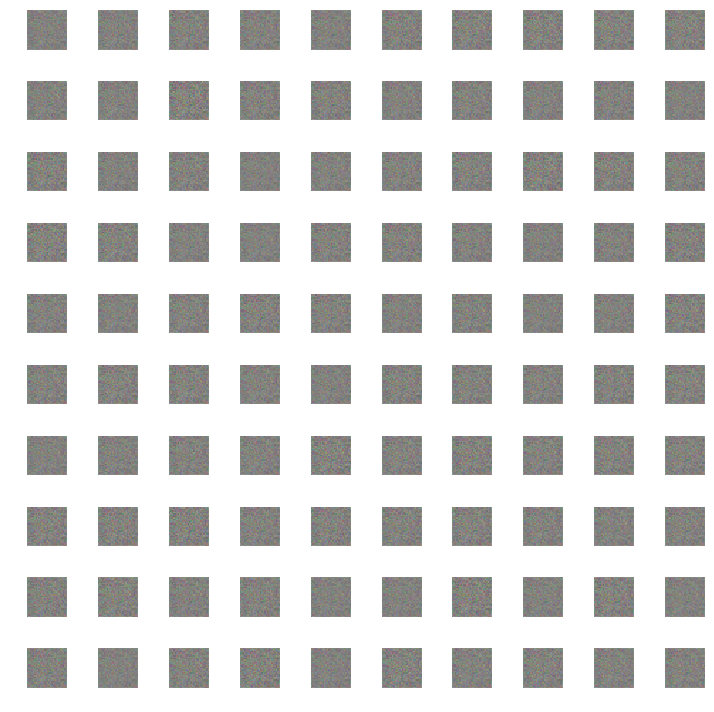

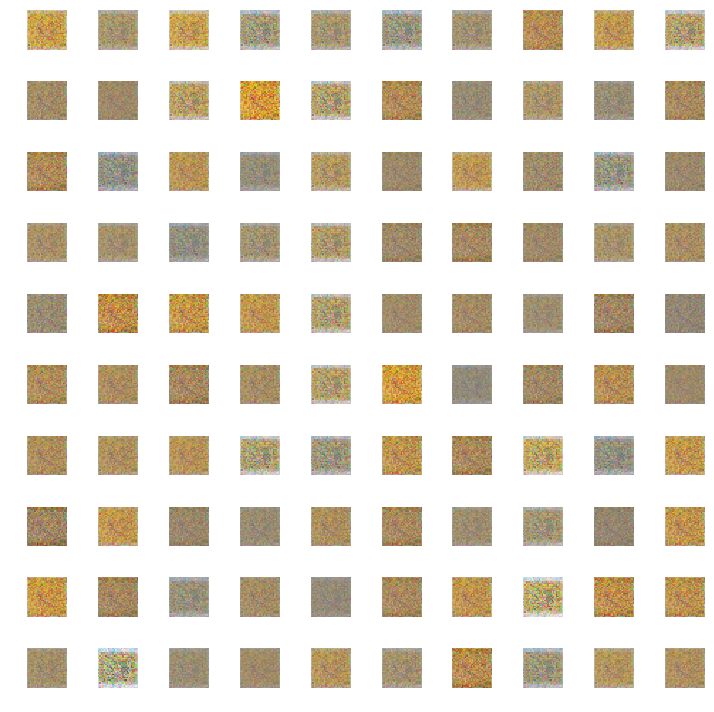

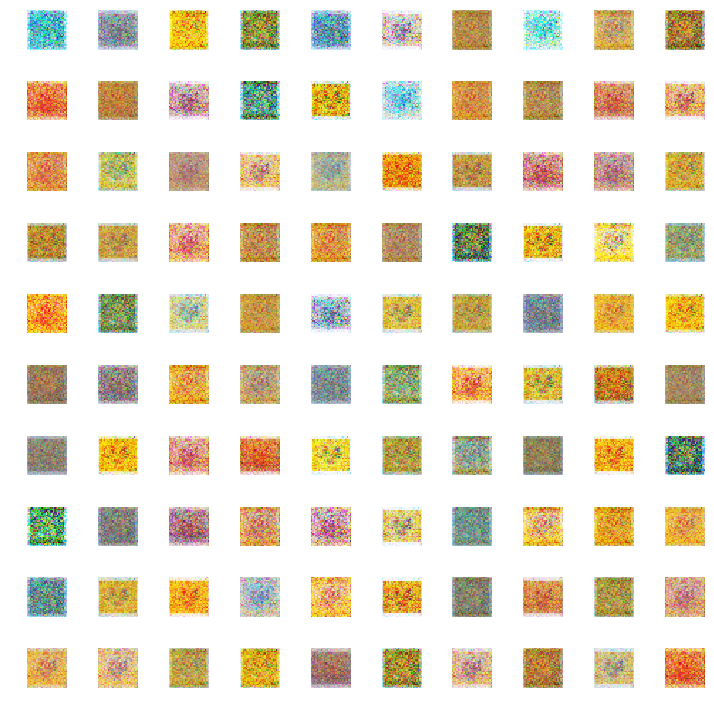

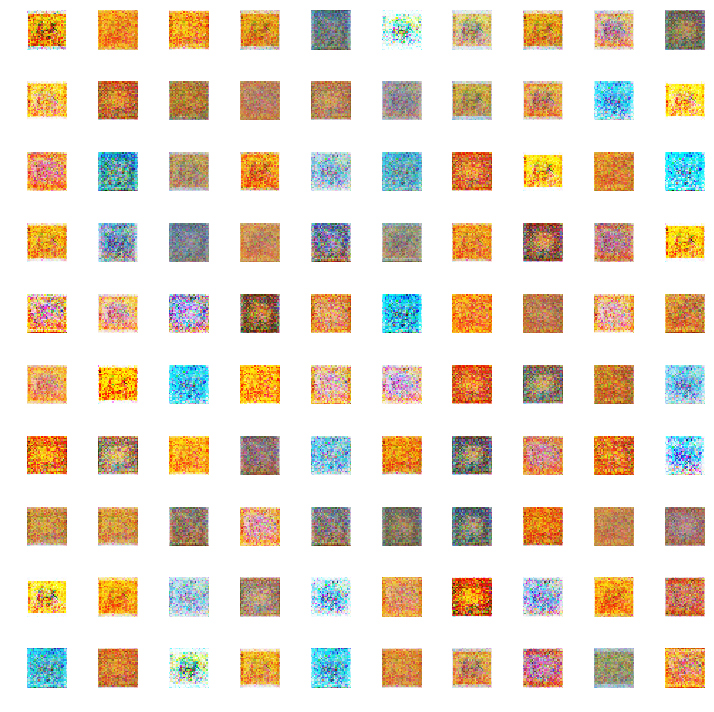

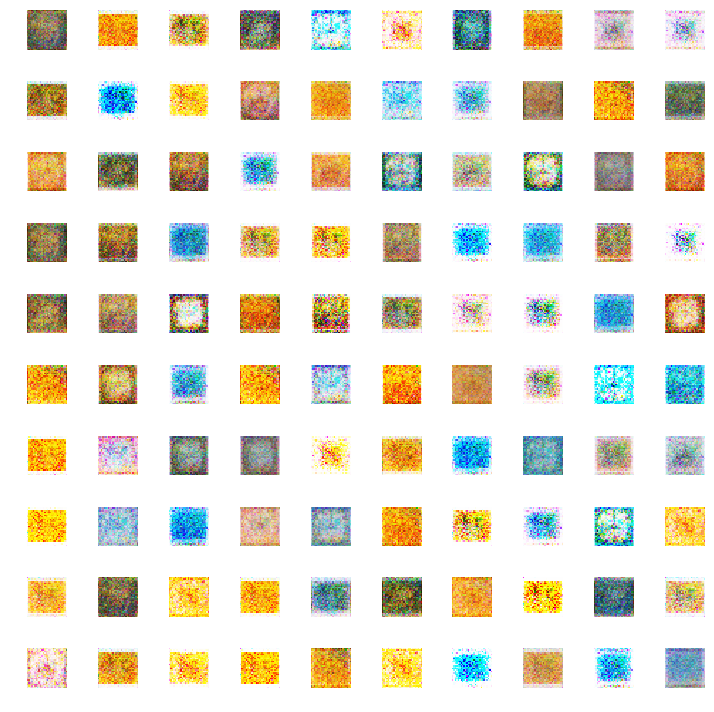

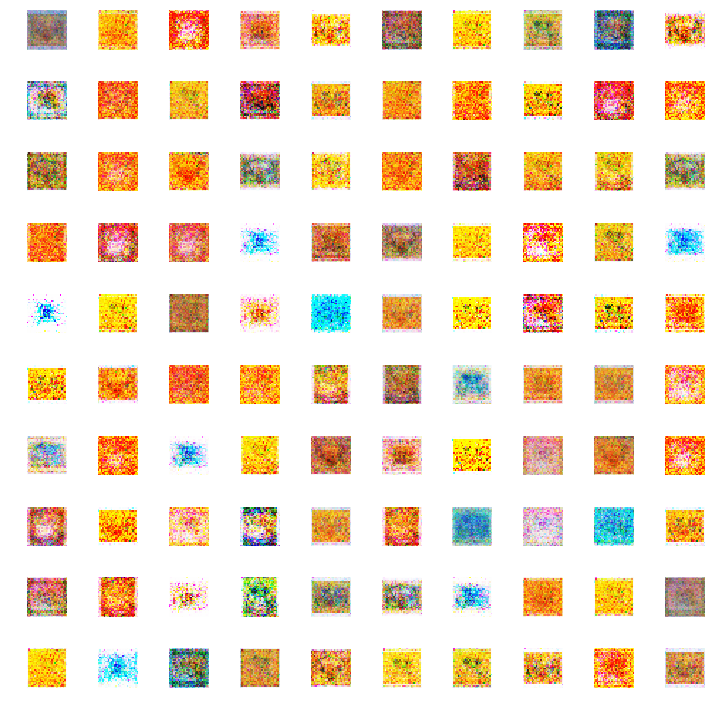

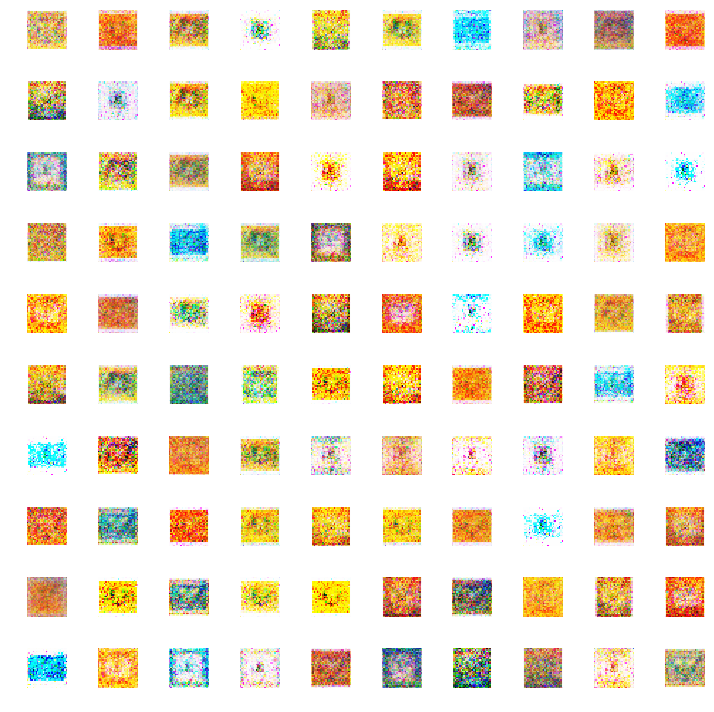

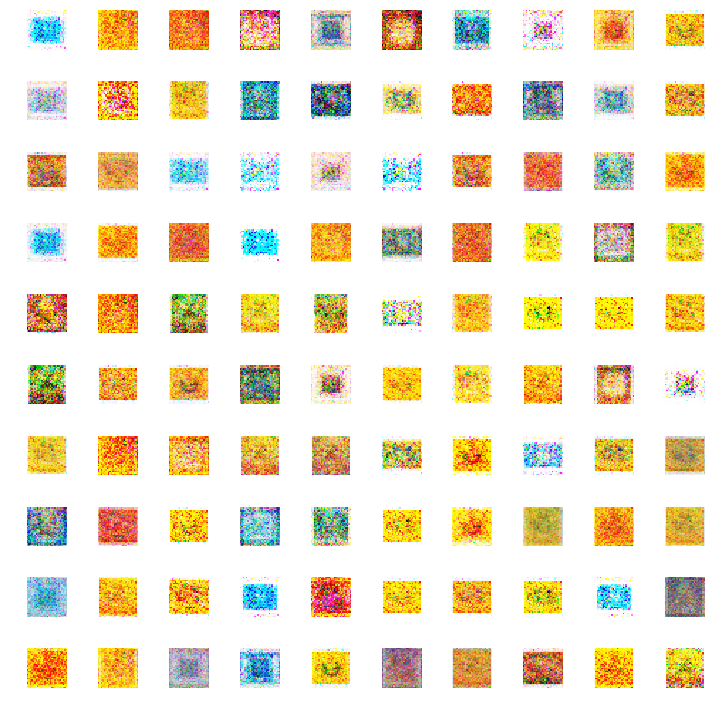

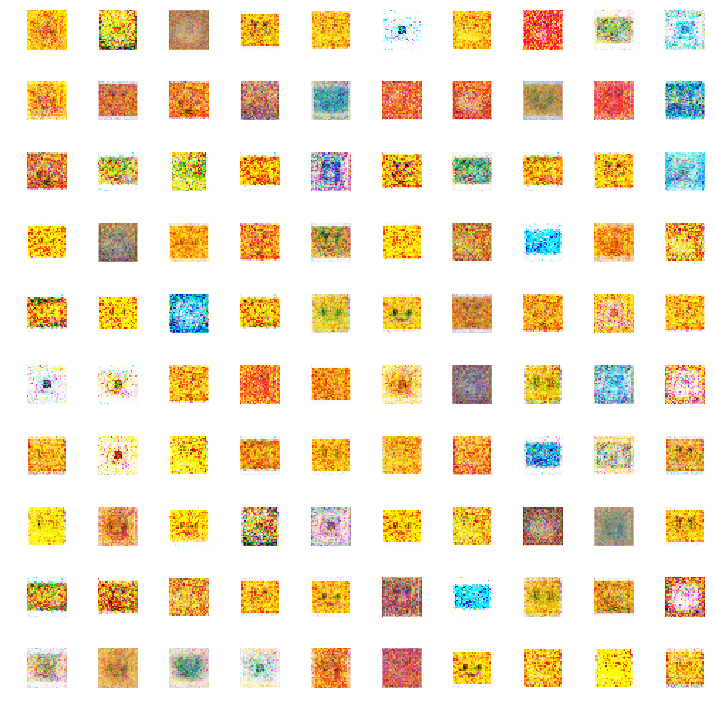

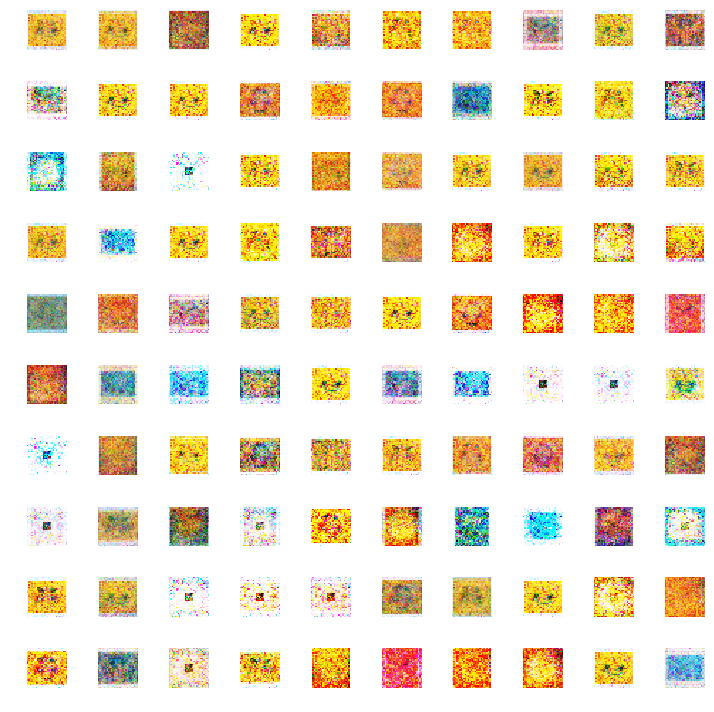

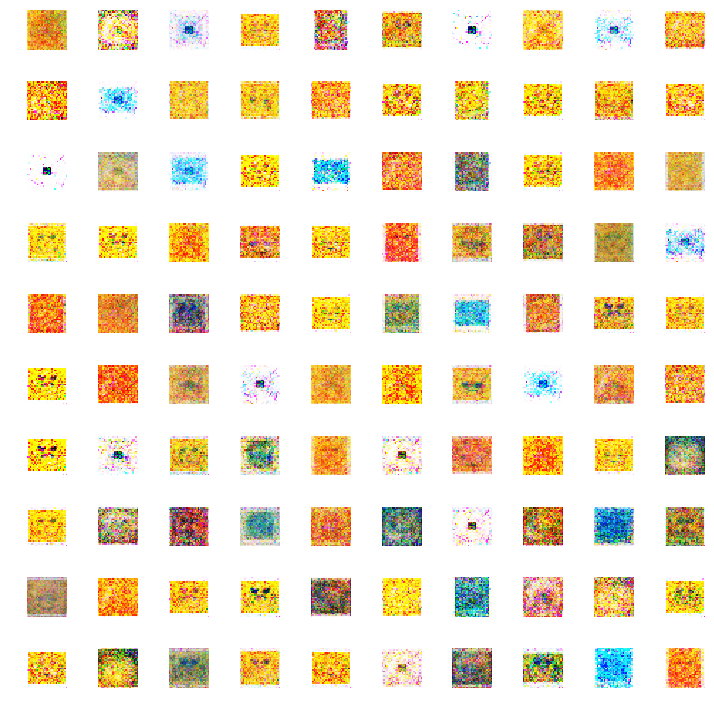

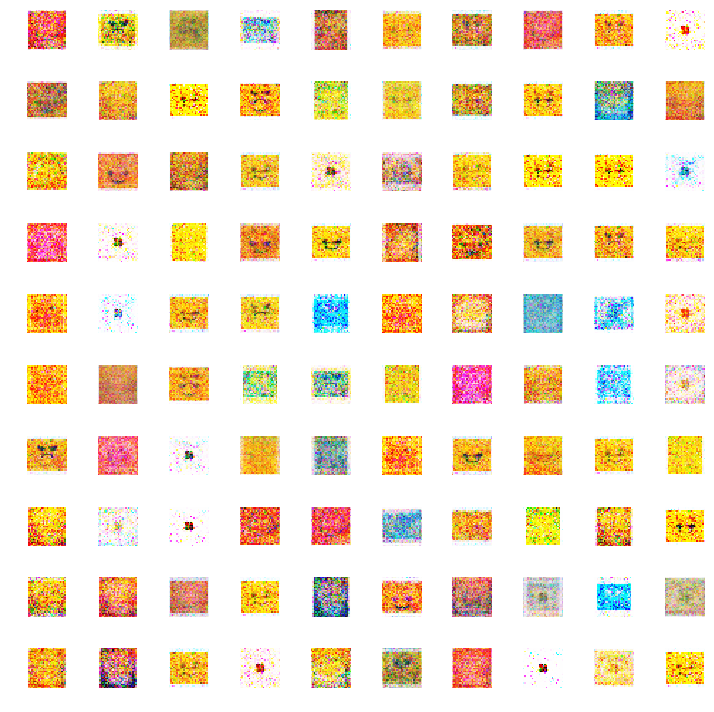

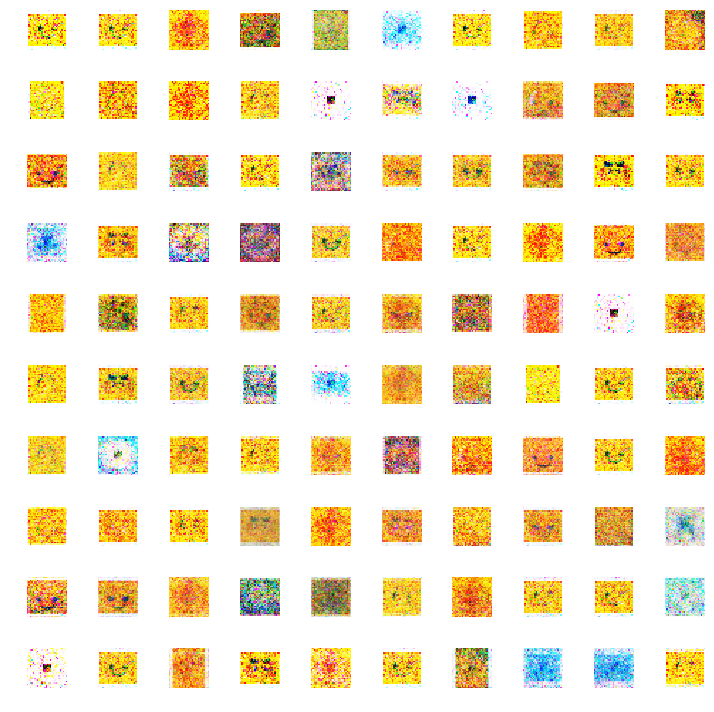

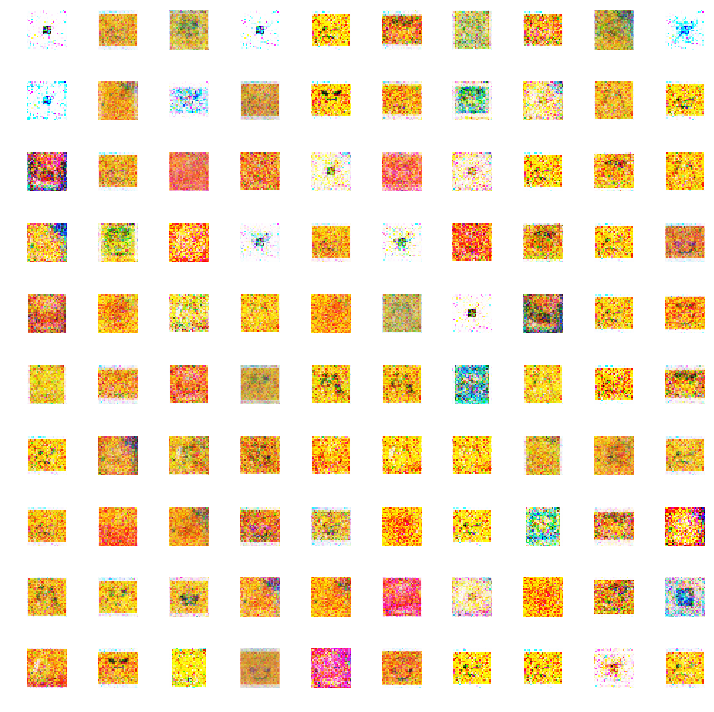

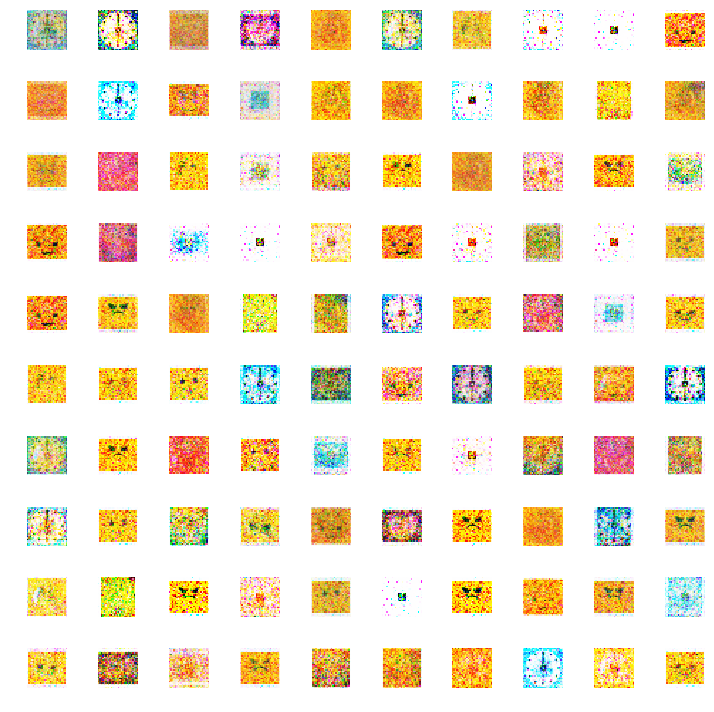

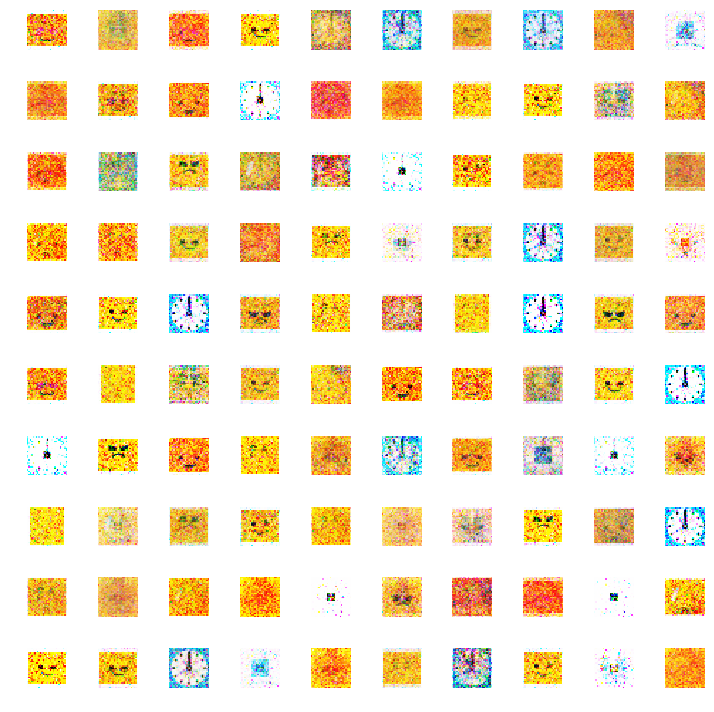

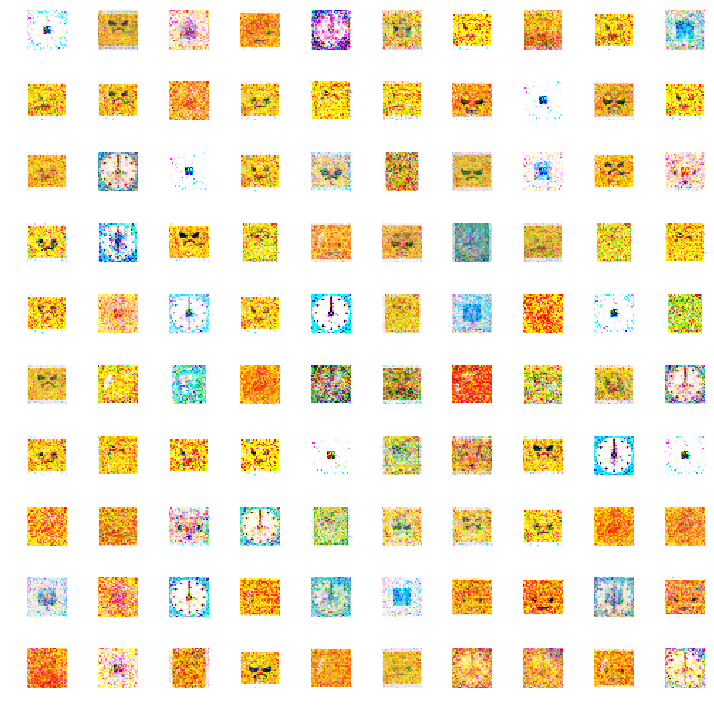

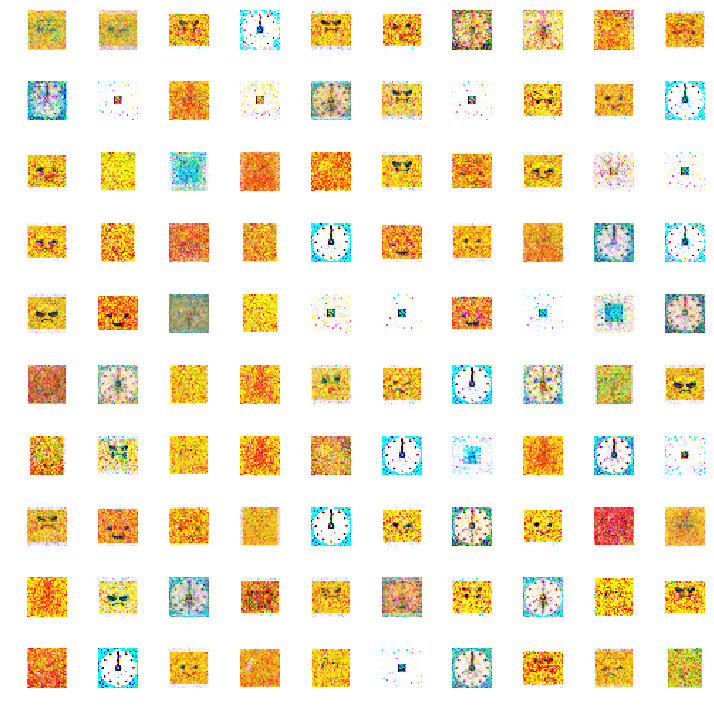

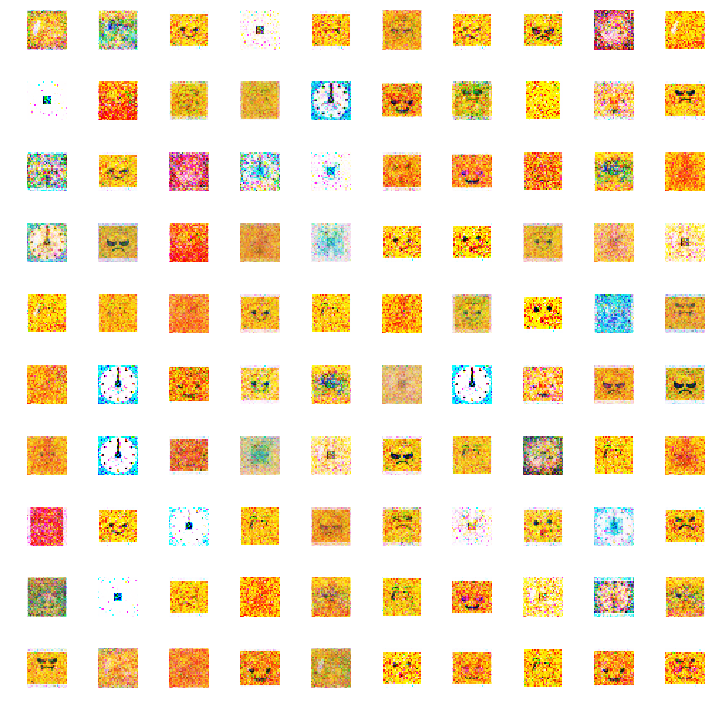

In [131]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, _, _, _ = load_emoji_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] // batch_size
 
    # Build our GAN netowrk
    adam = Adam(lr=0.0002, beta_1=0.5)
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)
 
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, random_dim,
                                                    size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
 
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)
 
    plot_generated_images(2, generator)

train(400, 64)

# Resources and Stretch Goals

Stretch goals
- [emoji-data](https://github.com/iamcal/emoji-data) - more, bigger, emoji
- [Slackmojis](https://slackmojis.com) - even more - many of them animated, which would be a significant additional challenge (probably not something for a day)

Resources
- [StyleGAN Explained](https://towardsdatascience.com/explained-a-style-based-generator-architecture-for-gans-generating-and-tuning-realistic-6cb2be0f431) - blog post describing GANs and StyleGAN in particular
- [Implementing GANs in TensorFlow](https://blog.paperspace.com/implementing-gans-in-tensorflow/) - blog post showing TF implementation of a simple GAN
- [Training GANs using Google Colaboratory](https://towardsdatascience.com/training-gans-using-google-colaboratory-f91d4e6f61fe) - an approach using Torch and GPU instances
- [Gym](https://gym.openai.com) - a toolkit for reinforcement learning, another innovative ML approach
- [deep emoji generative adversarial network](https://github.com/anoff/deep-emoji-gan) - yes, the idea of an emoji GAN has been done - so check out this extended analysis of the results
- [DeepMoji](http://deepmoji.mit.edu) - not a GAN, but a cool application of deep learning to emoji